# **Data preprocessing**

**IMPORTANT**: Main part of the notebook is done before 25.May.2023.

On 25.May we got new feedback from supervisor. Some UPDATEs are made at the section 4.
However, due to the limited time, the major part stays same as before. 

## 0 Recap from **Data understanding**
- four Sensors selected:
    - **Accelerometer**: measures **linear acceleration** and the vibration. Units are **meters per second squared (𝑚/𝑠2)** or **G- forces (𝑔)**.
    - **Gravity**
    - **Gyroscope**: uses Earth's gravity to help determine orientation. Gyro sensors are devices that sense **angular velocity** which is the change in rotational angle per unit of time. Angular velocity is generally expressed in deg/s (**degrees per second**).
    - **Magnetometer**: is generally **assembled with an accelerometer and a gyroscope** into an **inertial unit**. It measures the change of a magnetic field at a particular location. The measurement units are Tesla (𝑇 ), and the sampling rate is from tens to hundreds of Hz.

- users: we will use data from the 6 iphone users. 
- activities: laufen, joggen, treppelaufen, velofahren, stehen, sitzen
- data are stored under ..Daten/Laufen/user-name/xxx.json 


## 1 Load libraries and conditions

In [15]:
import json
import glob
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import collections
from torch.utils.data import TensorDataset, random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
pd.set_option('display.max_columns', None) 

In [16]:
# some conditions
activity_lst = ['Laufen','Rennen','Velofahren','Treppenlaufen','Sitzen','Stehen']
all_user = ['Ben_Tran', 'Etienne_Roulet','Florin_Barbisch','Gabriel_Torres','Lea_Buetler','Manjavy_Kirupa','Ognjen_Colovic','Tobias_Buess','Weiping_Zhang','Yvo_Keller']
iphone_user = ['Etienne_Roulet','Gabriel_Torres','Manjavy_Kirupa','Ognjen_Colovic','Weiping_Zhang','Yvo_Keller']
android_user = ['Ben_Tran', 'Florin_Barbisch','Lea_Buetler','Tobias_Buess']
new_user = ['anonymous']
sensor_lst = ['Magnetometer', 'Accelerometer', 'Gyroscope', 'Gravity'] # selected sensors
train_iphone_user = ['Etienne_Roulet','Gabriel_Torres','Ognjen_Colovic','Weiping_Zhang','Yvo_Keller']
test_iphone_user = ['Manjavy_Kirupa']
encoding_rule = {'Laufen': 0, 'Rennen': 1, 'Sitzen': 2, 'Stehen': 3, 'Treppenlaufen': 4, 'Velofahren': 5}

## 2 check data quantity - how many json files are available for each activity?
- UNTIL 25.MAY, We have in total 186 json files available, only around 50% as we expected. 
- Data class is well balanced, slightly more data in Treppenlaufen, slightly less in Velofahren and Sitzen. Later we will still apply over- or undersampling to balance the trainset classes.

In [3]:

activity_label = [] # a list to append activity label from each json file
for i in range(len(activity_lst)): 
    for j in range(len(iphone_user)):
        path_2 = f'{activity_lst[i]}/{iphone_user[j]}/' # second part of the path  
        path = os.path.join('../Daten/',path_2) # merge two path together. e.g., '../Daten/Laufen/Weiping_Zhang'
        json_files_directories = glob.glob(os.path.join(path, "*.json")) 
        for json_file in json_files_directories:
            activity_label.append(activity_lst[i])

label_counts = Counter(activity_label)
total_labels = len(activity_label)
print('we have in total {} json files recorded by iphone users'.format(total_labels))
label_proportions = {label: count / total_labels for label, count in label_counts.items()}
label_counts, label_proportions

we have in total 186 json files recorded by iphone users


(Counter({'Laufen': 31,
          'Rennen': 31,
          'Velofahren': 28,
          'Treppenlaufen': 35,
          'Sitzen': 29,
          'Stehen': 32}),
 {'Laufen': 0.16666666666666666,
  'Rennen': 0.16666666666666666,
  'Velofahren': 0.15053763440860216,
  'Treppenlaufen': 0.1881720430107527,
  'Sitzen': 0.15591397849462366,
  'Stehen': 0.17204301075268819})

## 3 Data preprocessing
### 3.0 some ideas and possible strategies for preprocessing

some users have some very long records, while most of other records are between 1 minute and 2 minutes.

#### 3.0.1 new unseen users in test set OR mixed users and train-test-split?
Our first discussion is, if we should use completely new unseen users in test set or first mix all users' data then train-test-split. Both methods have their strengths and limitations: 

- new unseen users in test set:
    - (+) provide a more realistic assessment of model's performance on new, unseen data
    - (-) test set: may have limited sample size, this can affect the statistical evaluation.
    - (-) potential bias: if new users in test set are significantly different (due to user behavior, preferences) from the users in training set, the bias may therefore affect model's performance.


- mixed users and split into train test sets:
    - (+) provide a more reliable evaluation of the model's performance due to a larger test set
    - (+) balanced representation of user behaviors and preferences
    - (-) limited assessment of generalization: model may perform well on users it has seen during training, but struggle with new unseen users. 

Our choices:
- We will include both strategies in the following preprocessing pipeline and modeling, though we still face the problems of: 
    - only one user has collected all 6 activity data, other five users have collected only part of activities data; 
    - for the first strategie, if we put this user in testset, we will get very small trainset. this means, we will have to put a user who has only collected part of activities in the testset. This will of course affect the statistical evaluation.
    - We have data from only 6 users, this is a relative small number, thus this may limit the models' ability to distinguish the activity patterns also from new unseen users.

#### 3.0.2 how long should a window be? With overlapping or not?
- **200/400 time steps** = around 2 or 4 seconds: 2 seconds and 1.8 seconds are the most often used length of HAR in relevant papers. Together with our own personal experience about the 6 activities, 2 seconds could be reasonable. To be safe, we also take a doubled length (4 seconds).
- **no/50% overlapping**: 50% overlapping is often used in HAR papers. We also includes no overlapping for comparison.
- together we will four different types of window settings to start, if all perform badly, we will tune the two parameters.

### 3.1 preprocessing steps
- read_json: read one json file, keep only the selected sensor data, and form it to a wide table (with features of x_gravity,y_gravity,...)
- time_window: select windows of time series data, here we could decide from which time point to start the window, the time gap between two windows (this may generate overlappings between windows), the length of each window, and how many windows. Finally, we will get multiple windows, where each window is a dataframe with shape of win_length * number_of_features
- jsons_to_tensor: read all json file given a main path with selected users, selected sensors, selected activities, and process each file through the pipeline read_json, time_window, label_encode. After all, we get a concate tensor file with input data of all windows, and a tensor file with label of all windows.
- re_sample_tensors: under- or oversampling. This should only take only train set data. 
- pipeline_preprocessing: finally pipeline up all steps. With the pipeline, we have the possibilities to generate two types (in total 8 groups) of dataset:

### 3.2 detailed preprocessing pipeline


- get all json files from the given main path
    - for each json file
        - convert to dataframe
        - keep selected sensor data
        - reform table from long to wide
        - extract n windows from the table, and concate all windows in a tensor, concate all labels in a list. Here we have applied 4 different windows parameter settings:
            - 400 time steps & no overlapping: 4 windows per json file 
            - 400 time steps & 50% overlapping: 8 windows per json file 
            - 200 time steps & no overlapping: 8 windows per json file 
            - 200 time steps & 50% overlapping: 16 windows per json file 

    - finally, after we loop through all json files in path, encode labels (with fixed encoding rule) from string to number, and store in a tensor
    - now, we have all windows in an input tensor, all corresponding numeric labels in a output tensor
- train & test dataset
    - if we want Type-one dataset (5 iphone users in train set, 1 new unseen iphone user in test set):
        - put five users in user-list-1, one user in user-list-2: 
            - in this way, the final pipeline will generate a train-input-tensor, a train-output-tensor, a test-input-tensor, a test-output-tensor. 
    - if we want Type-two dataset (get all data from 6 iphone users, 80/20 split to train and test set):
        - put six users in user-list-1, zero user in user-list-2: 
            - in this way, the final pipeline will generate a input-tensor, a output-tensor
            - then split them to train and test set
- now we get input & output tensors of train & test
- normalization: normalize both the train and test sets based on train set
- resampling: apply under- or oversampling on ONLY TRAIN SET
- output all needed files


In [17]:
# read one record in json form
def read_json(path, sensor_lst, activity_label):
    ''' 
    read one json file, and make it to a wide table (with features: x_gravity,...)
    ---
    Input: 
    path: the path of the json file, for example ../Daten/Laufen/Weiping_Zhang/9_iphone13mini-2023-03-12_12-05-03.json'
    sensor_lst: a list stores the sensors we would like to keep
    activity_label: the lable of this file
    
    ---
    Output:
    df_append: a wide (maybe scaled) dataframe with the column names in the form of x_gravity, y_gravity,... activity
    ---
    '''
    # an empty dataframe to store the tables from each sensor as a wide table
    df_append = pd.DataFrame() 
    # read the json file
    df = pd.read_json(path)
    # only keep the selected sensors, and drop the all-nan columns
    df = df[df['sensor'].isin(sensor_lst)].dropna(how='all',axis=1) 
    #df['seconds_elapsed'] = np.floor(df['seconds_elapsed'] *100)/100
    for i in range(len(sensor_lst)):
        # df_temp is a temporary table to store only one sensor data
        df_temp = df[df['sensor']==sensor_lst[i]][['seconds_elapsed', 'x', 'y', 'z']].set_index('seconds_elapsed')
        # rename the columns to the format x_sensor-i, y_sensor-i,....
        df_temp.columns = [f'{col}_{sensor_lst[i]}' for col in df_temp.columns]
        # concat together as a wide table
        df_append = pd.concat([df_append, df_temp], axis=1)
    
    df_append = df_append.dropna(how='all',axis=1) 
   # add the activity column 
    df_append['activity'] = activity_label
    
    return df_append


def time_window(df, start_point, win_length, time_gap, n_win):
    '''
    select windows of each time series data, each window is a dataframe with shape of win_length * (df.shape[1]-1)
    ---
    Input:
    df: input dataframe
    start_point: from which time point start to select the window, e.g., start from the 20 second
    win_length: time steps, how long is each window, e.g., 500 rows
    time_gap: the seconds between two start points, e.g., time_gap = 10: the first window from 20 second, the second windown from 30 second
    n_win: how many windows to select from each dataframe, either number or 'max'
   
    ---
    Output:
    X_tensor: all windows in a tensor (without 'activity')
    y_lst: all labels in a list
    '''
    # generate an empty tensor to store all windows
    X_tensor = torch.empty((0, win_length, 12)) 
    y_lst = []
    label = df['activity'].unique()[0]
    # keep only the data between 20-th and 40-th seconds
    df = df.iloc[start_point*100:-start_point*100]
    #df = df[(df['seconds_elapsed']>= 20) & (df['seconds_elapsed']<= max(df['seconds_elapsed'])-20)]
    if n_win != 'max':
        n_win = n_win
    elif n_win == 'max':
        n_win = (len(df)-win_length)//time_gap + 1
    start_ = 0
    for i in range(n_win):
        
        df_temp = df.iloc[start_ : start_ + win_length]

        #df_temp = df[df['seconds_elapsed']>= start_point].iloc[0:win_length,:]
        # append labels to list
        y_lst.append(label)
        # keep only the input features
        df_temp = df_temp.drop(['seconds_elapsed','activity'], axis=1)

        # transform the dataframe to numpy array
        X_array = df_temp.to_numpy() 
        # append the array to tensor
        X_tensor = torch.cat([X_tensor, torch.tensor(np.expand_dims(X_array, 0))], axis=0)
        start_ = start_ + time_gap

    return X_tensor, y_lst


def jsons_to_tensor(main_path,activity_lst,user_lst,sensor_lst, start_point, win_length,time_gap, n_win):
    ''' 
    read multiple json files, form each to wide tables with selected users, sensors, activities...
    --- 
    Input:
    main_path: the path of the main folder, e.g., '../Daten'
    activity_lst: the activities will be included
    user_lst: from which users data will be selected
    sensor_lst: selected sensors
    
    ---
    Output:
    X_tensor_concat: all input json dataframes splitted in windows as a tensor
    y_tensor: a sensor stores labels of the corresponding dataframes
    label_tuples: e.g. (0,Laufen),(1,Joggen)...
    '''
    # generate an empty tensor to store all windows
    X_tensor_concat = torch.empty((0, win_length, 3*len(sensor_lst)))
    activity_label = [] # a list to append activity label from each json file
    # read the data from the folder of one activity
    for i in range(len(activity_lst)): 
        for j in range(len(user_lst)):
            path_2 = f'{activity_lst[i]}/{user_lst[j]}/' # second part of the path  
            path = os.path.join(main_path,path_2) # merge two path together. e.g., '../Daten/Laufen/Weiping_Zhang'
            json_files_directories = glob.glob(os.path.join(path, "*.json")) # get all the json files directory in a list
            for json_path in json_files_directories:
                # read json file and convert it to wide table
                df_temp = read_json(json_path, sensor_lst, activity_lst[i]).reset_index() 
                if max(df_temp['seconds_elapsed']) > 60 and df_temp.shape[0] >6000: 
                    # select one or more windows from the dataframe
                    df_temp_windows = time_window(df_temp, start_point, win_length,time_gap, n_win)
                    X_tensor = df_temp_windows[0]
                    y_lst =  df_temp_windows[1]
                    # add the input X or y to the main tensor
                    X_tensor_concat = torch.cat((X_tensor_concat, X_tensor), dim=0)
                    activity_label.extend(y_lst) 
    # encode labels
    encoder = LabelEncoder()
    y_tensor = torch.tensor(np.array([encoding_rule[label] for label in activity_label]))
    label_tuples = list(encoding_rule.items())
    #y_tensor = torch.tensor(encoder.fit_transform(activity_label))
    #label_tuples = list(zip(range(len(encoder.classes_)), encoder.classes_))
    return X_tensor_concat, y_tensor, label_tuples


def re_sample_tensors(train_X, train_y,sampling_type):
    '''
    train_X: a tensor with shape of (n_samples, n_time_steps, n_features)
    train_y: a tensor with shape of (n_samples)
    re-sampling_type: 'over' or 'under'
    re-sampling the data to make it balanced
    only perform oversampling ON TRAIN set, NOT ON TEST set. '''
    # Count the instances of each class
    unique_classes, counts = torch.unique(train_y, return_counts=True)
    min_count = torch.min(counts).item()

    # Under-sampling each class in the training set
    if sampling_type == 'under':
        train_indices = []
        for label in unique_classes:
            label_indices = torch.where(train_y == label)[0]
            sampled_indices = np.random.choice(label_indices, min_count, replace=False)
            train_indices.extend(sampled_indices)

        train_X_resampled = train_X[train_indices]
        train_y_resampled = train_y[train_indices]
    

    # Over-sampling each class in the training set
    elif sampling_type == 'over':
        train_indices = []
        max_count = np.max(np.bincount(train_y.numpy()))

        for label in unique_classes:
            label_indices = torch.where(train_y == label)[0]
            sampled_indices = np.random.choice(label_indices, max_count, replace=True)
            train_indices.extend(sampled_indices)

        train_X_resampled = train_X[train_indices]
        train_y_resampled = train_y[train_indices]
    return train_X_resampled, train_y_resampled                


def pipeline_preprocessing(main_path,activity_lst,train_user_lst,test_user_lst,sensor_lst, start_point, win_length,time_gap, n_win, sampling_type,group_name):

    '''
    this pipeline is for two different types of preprocessing:
        1. when train and test set have different users. e.g. train set: user1, user2, user3, user4, user5; test set: user6.
        2. (set test_user_lst = [])when preprocess data of all selected users, afterwards split to train and test set. 
    include normalization, and label encoding
    
    train-set-split -> normalization -> re-sampling (over or under)

    -----
    Output:
    train_dataset, test_dataset: for deep learning models, both are TensorDataset , the form should be (sample, feature, time_steps)
    train_X_resampled, train_y_resampled, test_X_normalized, test_y, label_tuples: for not-deep learning models, 
                                                                                    same content as train_dataset, test_dataset, 
                                                                                    but in form (sample, time_steps, feature)
    '''
    # when select different users for train set and test set. e.g. 5 users for train set, 1 user for test set
    if len(test_user_lst) > 0:
        train_set = jsons_to_tensor(main_path,activity_lst,train_user_lst,sensor_lst, start_point, win_length,time_gap, n_win)
        train_X = train_set[0]
        train_y = train_set[1]
        test_set = jsons_to_tensor(main_path,activity_lst,test_user_lst,sensor_lst, start_point, win_length,time_gap, n_win)
        test_X = test_set[0]
        test_y = test_set[1]
        label_tuples = train_set[2]

    # data from all users, then split to train and test set
    elif len(test_user_lst) == 0:
        data_set = jsons_to_tensor(main_path,activity_lst,train_user_lst,sensor_lst, start_point, win_length,time_gap, n_win)
        tensor_dataset = TensorDataset(data_set[0],data_set[1])
        n_train = int(len(tensor_dataset) * 0.8)
        n_test = len(tensor_dataset) - n_train
        torch.manual_seed(42)
        train_set, test_set = random_split(tensor_dataset, [n_train, n_test])
        train_X, train_y = train_set[:]
        test_X, test_y = test_set[:]
        label_tuples = data_set[2]

    # normalize input data 
    # after normalization, the mean and standard deviation of each feature should be close to 0 and 1
    train_X = train_X.float()
    test_X = test_X.float()
    # Calculate the mean and standard deviation of the training set along the time dimension (dimension 1)
    mean = torch.mean(train_X, dim=(0, 1))
    std = torch.std(train_X, dim=(0, 1))
    # Normalize both the train and test sets based on train set (calculated mean and standard deviation)
    train_X_normalized = (train_X - mean) / std
    test_X_normalized = (test_X - mean) / std
    
    # re-sampling
    re_sampl_result = re_sample_tensors(train_X_normalized, train_y,sampling_type)
    train_X_resampled = re_sampl_result[0]
    train_y_resampled = re_sampl_result[1]
    # Create TensorDataset for the train and test sets (will be used for deeplearning models), and the form should be (sample, feature, time_steps)
    train_dataset = TensorDataset(train_X_resampled.transpose(1, 2), train_y_resampled)
    test_dataset = TensorDataset(test_X_normalized.transpose(1, 2), test_y)

    # save locally
    torch.save(train_X_resampled, f'../Daten/{group_name}/train_X.pt')
    torch.save(train_y_resampled, f'../Daten/{group_name}/train_y.pt')
    torch.save(test_X_normalized, f'../Daten/{group_name}/test_X.pt')
    torch.save(test_y, f'../Daten/{group_name}/test_y.pt')
    torch.save(train_dataset, f'../Daten/{group_name}/train_dataset.pt')
    torch.save(test_dataset, f'../Daten/{group_name}/test_dataset.pt')

    # check the shape of the tensors
    print('trainset size:',train_X_resampled.size(), train_y_resampled.size(), '; testset size:',test_X_normalized.size(), test_y.size())
    print(label_tuples)
    print("Train label balance:", collections.Counter(train_y_resampled.numpy()))
    print("Test label balance:", collections.Counter(test_y.numpy()))
    return train_dataset, test_dataset, train_X_resampled, train_y_resampled, test_X_normalized, test_y, label_tuples


### 3.3 final 8 groups of dataset

- finally we got 8 groups of dataset:
    - **Type-one**: five users in trainset, one unseen user in testset
        - group 1: 400 time steps & no overlapping: 4 windows per json file 
        - group 2: 400 time steps & 50% overlapping: 8 windows per json file 
        - group 3: 200 time steps & no overlapping: 8 windows per json file 
        - group 4: 200 time steps & 50% overlapping: 16 windows per json file 
    - **Type-two**: six users in full dataset -> 80/20 train-test split
        - group 5: 400 time steps & no overlapping: 4 windows per json file 
        - group 6: 400 time steps & 50% overlapping: 8 windows per json file 
        - group 7: 200 time steps & no overlapping: 8 windows per json file 
        - group 8: 200 time steps & 50% overlapping: 16 windows per json file 

- save all files locally

#### 3.3.1 Type-one: 5 users in trainset, 1 unseen user in testset

In [39]:
# group 1 (400_no_ol)
# 400 steps & no overlapping: 4 windows -> time gap = 4 seconds
result_1 = pipeline_preprocessing('../Daten',activity_lst,train_iphone_user,test_iphone_user,sensor_lst, 20, 400, 400, 4, 'over','group_1')
# for deep learning models in form (sample, feature, time_steps)
train_dataset1 = result_1[0]
test_dataset1 = result_1[1]

# for not-deep learning models in form (sample, time_steps, feature)
train_X1 = result_1[2]
train_y1 = result_1[3]
test_X1 = result_1[4]
test_y1 = result_1[5]

trainset size: torch.Size([744, 400, 12]) torch.Size([744]) ; testset size: torch.Size([200, 400, 12]) torch.Size([200])
[('Laufen', 0), ('Rennen', 1), ('Sitzen', 2), ('Stehen', 3), ('Treppenlaufen', 4), ('Velofahren', 5)]
Train label balance: Counter({0: 124, 1: 124, 2: 124, 3: 124, 4: 124, 5: 124})
Test label balance: Counter({5: 44, 4: 40, 2: 40, 3: 40, 1: 36})


In [41]:
# group 2 (400_50_ol)
# 400 steps & 50% overlapping: 8 windows -> time gap = 2 seconds
result_2 = pipeline_preprocessing('../Daten',activity_lst,train_iphone_user,test_iphone_user,sensor_lst, 20, 400, 200, 8, 'over','group_2')
# for deep learning models in form (sample, feature, time_steps)
train_dataset2 = result_2[0]
test_dataset2 = result_2[1]

# for not-deep learning models in form (sample, time_steps, feature)
train_X2 = result_2[2]
train_y2 = result_2[3]
test_X2 = result_2[4]
test_y2 = result_2[5]
# label tuples
label_pairs_2 = result_2[6]

trainset size: torch.Size([1488, 400, 12]) torch.Size([1488]) ; testset size: torch.Size([400, 400, 12]) torch.Size([400])
[('Laufen', 0), ('Rennen', 1), ('Sitzen', 2), ('Stehen', 3), ('Treppenlaufen', 4), ('Velofahren', 5)]
Train label balance: Counter({0: 248, 1: 248, 2: 248, 3: 248, 4: 248, 5: 248})
Test label balance: Counter({5: 88, 4: 80, 2: 80, 3: 80, 1: 72})


In [42]:
# group 3 (200_no_ol)
# 200 steps & no overlapping: 8 windows -> time gap = 2 seconds
result_3 = pipeline_preprocessing('../Daten',activity_lst,train_iphone_user,test_iphone_user,sensor_lst, 20, 200, 200, 8, 'over','group_3')
# for deep learning models in form (sample, feature, time_steps)
train_dataset3 = result_3[0]
test_dataset3 = result_3[1]

# for not-deep learning models in form (sample, time_steps, feature)
train_X3 = result_3[2]
train_y3 = result_3[3]
test_X3 = result_3[4]
test_y3 = result_3[5]
# label tuples
label_pairs_3 = result_3[6]

trainset size: torch.Size([1488, 200, 12]) torch.Size([1488]) ; testset size: torch.Size([400, 200, 12]) torch.Size([400])
[('Laufen', 0), ('Rennen', 1), ('Sitzen', 2), ('Stehen', 3), ('Treppenlaufen', 4), ('Velofahren', 5)]
Train label balance: Counter({0: 248, 1: 248, 2: 248, 3: 248, 4: 248, 5: 248})
Test label balance: Counter({5: 88, 4: 80, 2: 80, 3: 80, 1: 72})


In [43]:
# group 4 (200_50_ol)
# 200 steps & 50% overlapping: 16 windows -> time gap = 1 seconds
result_4 = pipeline_preprocessing('../Daten',activity_lst,train_iphone_user,test_iphone_user,sensor_lst, 20, 200, 100, 16, 'over','group_4')
# for deep learning models in form (sample, feature, time_steps)
train_dataset4 = result_4[0]
test_dataset4 = result_4[1]

# for not-deep learning models in form (sample, time_steps, feature)
train_X4 = result_4[2]
train_y4 = result_4[3]
test_X4 = result_4[4]
test_y4 = result_4[5]

trainset size: torch.Size([2976, 200, 12]) torch.Size([2976]) ; testset size: torch.Size([800, 200, 12]) torch.Size([800])
[('Laufen', 0), ('Rennen', 1), ('Sitzen', 2), ('Stehen', 3), ('Treppenlaufen', 4), ('Velofahren', 5)]
Train label balance: Counter({0: 496, 1: 496, 2: 496, 3: 496, 4: 496, 5: 496})
Test label balance: Counter({5: 176, 4: 160, 2: 160, 3: 160, 1: 144})


#### 3.3.2 Type-two: 6 users in full dataset. 80/20 split to train and test set

In [44]:
# group 5 (400_no_ol)
# 400 steps & no overlapping: 4 windows -> time gap = 4 seconds
result_5 = pipeline_preprocessing('../Daten',activity_lst,iphone_user,[],sensor_lst, 20, 400, 4, 4, 'over','group_5')
# for deep learning models in form (sample, feature, time_steps)
train_dataset5 = result_5[0]
test_dataset5 = result_5[1]

# for not-deep learning models in form (sample, time_steps, feature)
train_X5 = result_5[2]
train_y5 = result_5[3]
test_X5 = result_5[4]
test_y5 = result_5[5]

# label tuples
label_pairs_5 = result_5[6]

trainset size: torch.Size([690, 400, 12]) torch.Size([690]) ; testset size: torch.Size([144, 400, 12]) torch.Size([144])
[('Laufen', 0), ('Rennen', 1), ('Sitzen', 2), ('Stehen', 3), ('Treppenlaufen', 4), ('Velofahren', 5)]
Train label balance: Counter({0: 115, 1: 115, 2: 115, 3: 115, 4: 115, 5: 115})
Test label balance: Counter({0: 28, 2: 27, 5: 26, 1: 23, 3: 23, 4: 17})


In [45]:
# group 6 (400_50_ol)
# 400 steps & 50% overlapping: 8 windows -> time gap = 2 seconds
result_6 = pipeline_preprocessing('../Daten',activity_lst,iphone_user,[],sensor_lst, 20, 400, 2, 8, 'over','group_6')
# for deep learning models in form (sample, feature, time_steps)
train_dataset6 = result_6[0]
test_dataset6 = result_6[1]

# for not-deep learning models in form (sample, time_steps, feature)
train_X6 = result_6[2]
train_y6 = result_6[3]
test_X6 = result_6[4]
test_y6 = result_6[5]

trainset size: torch.Size([1230, 400, 12]) torch.Size([1230]) ; testset size: torch.Size([288, 400, 12]) torch.Size([288])
[('Laufen', 0), ('Rennen', 1), ('Sitzen', 2), ('Stehen', 3), ('Treppenlaufen', 4), ('Velofahren', 5)]
Train label balance: Counter({0: 205, 1: 205, 2: 205, 3: 205, 4: 205, 5: 205})
Test label balance: Counter({4: 59, 0: 56, 2: 46, 3: 44, 5: 43, 1: 40})


In [46]:
# group 7 (200_no_ol)
# 200 steps & no overlapping: 8 windows -> time gap = 2 seconds
result_7 = pipeline_preprocessing('../Daten',activity_lst,iphone_user,[],sensor_lst, 20, 200, 2, 8, 'over','group_7')
# for deep learning models in form (sample, feature, time_steps)
train_dataset7 = result_7[0]
test_dataset7 = result_7[1]

# for not-deep learning models in form (sample, time_steps, feature)
train_X7 = result_7[2]
train_y7 = result_7[3]
test_X7 = result_7[4]
test_y7 = result_7[5]

trainset size: torch.Size([1230, 200, 12]) torch.Size([1230]) ; testset size: torch.Size([288, 200, 12]) torch.Size([288])
[('Laufen', 0), ('Rennen', 1), ('Sitzen', 2), ('Stehen', 3), ('Treppenlaufen', 4), ('Velofahren', 5)]
Train label balance: Counter({0: 205, 1: 205, 2: 205, 3: 205, 4: 205, 5: 205})
Test label balance: Counter({4: 59, 0: 56, 2: 46, 3: 44, 5: 43, 1: 40})


In [47]:
# group 8 (200_50_ol)
# 200 steps & 50% overlapping: 16 windows -> time gap = 1 seconds
result_8 = pipeline_preprocessing('../Daten',activity_lst,iphone_user,[],sensor_lst, 20, 200, 1, 16, 'over','group_8')
# for deep learning models in form (sample, feature, time_steps)
train_dataset8 = result_8[0]
test_dataset8 = result_8[1]

# for not-deep learning models in form (sample, time_steps, feature)
train_X8 = result_8[2]
train_y8 = result_8[3]
test_X8 = result_8[4]
test_y8 = result_8[5]

trainset size: torch.Size([2574, 200, 12]) torch.Size([2574]) ; testset size: torch.Size([576, 200, 12]) torch.Size([576])
[('Laufen', 0), ('Rennen', 1), ('Sitzen', 2), ('Stehen', 3), ('Treppenlaufen', 4), ('Velofahren', 5)]
Train label balance: Counter({0: 429, 1: 429, 2: 429, 3: 429, 4: 429, 5: 429})
Test label balance: Counter({0: 114, 2: 102, 4: 99, 5: 91, 3: 90, 1: 80})


### 3.4 check split distribution
- It is important to have the same distribution of classes in the training and test sets as in the original data. This will ensure the training and the evaluation of the model's performance is representative. The trainset data is already proceed with oversampling, so we will exam if the proportion of classes in the test set would be close to the whole dataset.
- Since the dataset 1 to 4 did not processed with train-test-split, we will only test the dataset groups 5 - 8.

In [13]:
# mapping from numbers to activities
mapping = dict([(0, 'Laufen'), (1, 'Rennen'), (2, 'Sitzen'), (3, 'Stehen'), (4, 'Treppenlaufen'), (5, 'Velofahren')])
def compare_proportions(full_data, test_data,group_nr):
    full_data = dict(full_data)
    print(f'Dataset {group_nr}')
    for activity in full_data:
        print(f'  - {activity}: Full data proportion: {full_data[activity]}, Test data proportion: {test_data.get(activity, 0)}')  

def compute_proportions(count_dict):
    '''calculate the proportion'''
    total = sum(count_dict.values())
    proportion_dict = {activity: round(count/total, 2) for activity, count in count_dict.items()}
    #compare_proportions(full_data,proportion_dict,group_nr)
    return proportion_dict

def plot_activity_distribution(count_dict,group_nr):
    '''plot the activity distribution'''
    if group_nr != 'full data':
        proportion_dict = compute_proportions(count_dict)
        string_proportion_dict = {mapping[key]: value for key, value in proportion_dict.items()}
    elif group_nr == 'full data':
        string_proportion_dict = count_dict
    plt.figure(figsize=(10, 3))
    plt.bar(string_proportion_dict.keys(), string_proportion_dict.values(), width=0.5, color='g')
    plt.xticks(rotation=0)
    plt.xlabel('Activity')
    plt.ylabel('Count')
    plt.title(f'Activity distribution for group {group_nr}')
    plt.show()

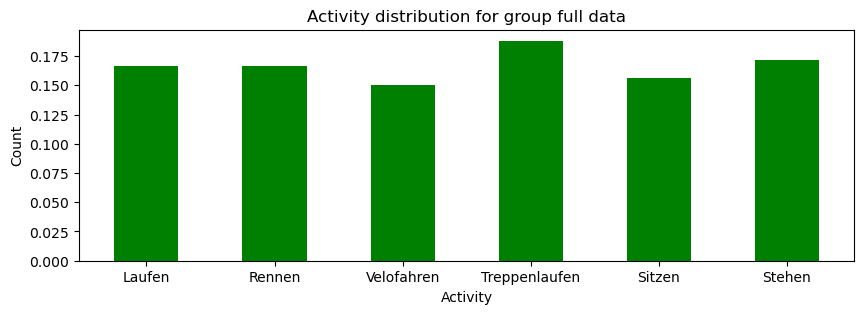

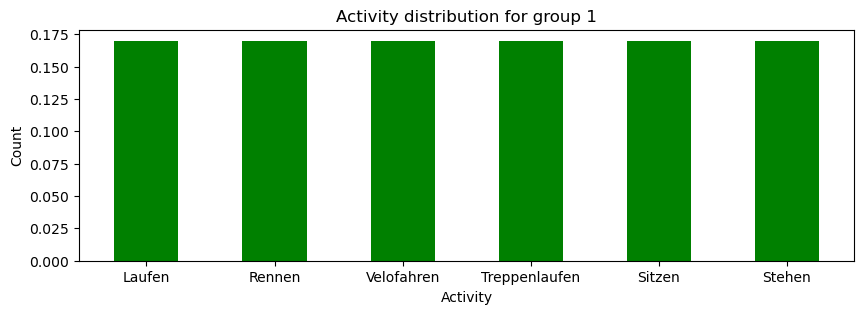

In [14]:
result_lst = [result_1,result_2,result_3,result_4,result_5,result_6,result_7,result_8]
plot_activity_distribution(label_proportions,'full data')
for i in range(len(result_lst)):
    test_dict = collections.Counter(result_lst[i][5].numpy())
    plot_activity_distribution(test_dict,i+1)

#### 3.4.1 result interpretation:

Now let's look at the label proportions of full dataset and testset

- Dataset 5: The proportions are fairly close, with 'Laufen', 'Velofahren' and 'Sitzen' being slightly over-represented and 'Treppenlaufen' being slightly under-represented in the test set.
- Dataset 6: The proportions are quite good, with slight over-representation of 'Laufen' and 'Velofahren' and slight under-representation of 'Rennen' and 'Sitzen'.
- Dataset 7: The proportions are very similar to dataset 6, indicating a reasonably good stratification.
- Dataset 8: The proportions are quite good, with slight over-representation of 'Laufen', 'Velofahren' and slight under-representation of 'Treppenlaufen' and 'Rennen'.



Overall, a small amount of variation in proportions is generally acceptable in sampling, all four datasets have good distribution of classes, therefore stratify is not necessary.

## 4 UPDATE: 25.May.2023



#### 3.0.2 same number of windows from each record OR as many as possible?
The length of our data is between 1 minute and half hour. Should we take same number of windows or as many windows from one record as possible?
- taking **same number of windows from each record**:
    - (+) ensure that each record contributes equally to training set
    - (+) help to prevent biases in the model if certain activities are over-represented in longer records
    - (-) may lose valuable information from the long records
- taking **as many windows as possible** from each record:
    - (+) use all available data, provide more information for learning
    - (+) increase data size
    - (-) longer records could dominate our dataset, introduce bias if these long records are not representative
    - (-) if certain activities tend to occur in longer records, model might become biased towards those activities.

In **our case, taking same number of windows** from each record would be a more suitable approach, because we won't lose valuable information from long records, the few long records will for sure be dominate our dataset and therefore introduce bias. 


## as many windows as possible from one record
group 9 - 12:
group 13 - 16: 

In [ ]:
# group 9 
# 400 steps & no overlapping
result_9 = pipeline_preprocessing('../Daten',activity_lst,train_iphone_user,test_iphone_user,sensor_lst, 20, 400, 400, 'max', 'over','group_9')
# group 10 
# 400 steps & 50% overlapping
result_10 = pipeline_preprocessing('../Daten',activity_lst,train_iphone_user,test_iphone_user,sensor_lst, 20, 400, 200, 'max', 'over','group_10')
# group 11 
# 200 steps & no overlapping
result_11 = pipeline_preprocessing('../Daten',activity_lst,train_iphone_user,test_iphone_user,sensor_lst, 20, 200, 200, 'max', 'over','group_11')
# group 12 
# 200 steps & 50% overlapping
result_12 = pipeline_preprocessing('../Daten',activity_lst,train_iphone_user,test_iphone_user,sensor_lst, 20, 200, 100, 'max', 'over','group_12')

trainset size: torch.Size([15648, 400, 12]) torch.Size([15648]) ; testset size: torch.Size([980, 400, 12]) torch.Size([980])
[('Laufen', 0), ('Rennen', 1), ('Sitzen', 2), ('Stehen', 3), ('Treppenlaufen', 4), ('Velofahren', 5)]
Train label balance: Counter({0: 2608, 1: 2608, 2: 2608, 3: 2608, 4: 2608, 5: 2608})
Test label balance: Counter({2: 328, 5: 203, 3: 197, 4: 136, 1: 116})
trainset size: torch.Size([15834, 200, 12]) torch.Size([15834]) ; testset size: torch.Size([1030, 200, 12]) torch.Size([1030])
[('Laufen', 0), ('Rennen', 1), ('Sitzen', 2), ('Stehen', 3), ('Treppenlaufen', 4), ('Velofahren', 5)]
Train label balance: Counter({0: 2639, 1: 2639, 2: 2639, 3: 2639, 4: 2639, 5: 2639})
Test label balance: Counter({2: 338, 5: 214, 3: 207, 4: 146, 1: 125})
trainset size: torch.Size([31596, 200, 12]) torch.Size([31596]) ; testset size: torch.Size([2035, 200, 12]) torch.Size([2035])
[('Laufen', 0), ('Rennen', 1), ('Sitzen', 2), ('Stehen', 3), ('Treppenlaufen', 4), ('Velofahren', 5)]
Train

In [ ]:
# group 13
# 400 steps & no overlapping
result_13 = pipeline_preprocessing('../Daten',activity_lst,iphone_user,[],sensor_lst, 20, 400, 400, 'max', 'over','group_13')
# group 14
# 400 steps & 50% overlapping
result_14 = pipeline_preprocessing('../Daten',activity_lst,iphone_user,[],sensor_lst, 20, 400, 200, 'max', 'over','group_14')
# group 15
# 200 steps & no overlapping
result_15 = pipeline_preprocessing('../Daten',activity_lst,iphone_user,[],sensor_lst, 20, 200, 200, 'max', 'over','group_15')
# group 16
# 200 steps & 50% overlapping
result_16 = pipeline_preprocessing('../Daten',activity_lst,iphone_user,[],sensor_lst, 20, 200, 100, 'max', 'over','group_16')

trainset size: torch.Size([6294, 400, 12]) torch.Size([6294]) ; testset size: torch.Size([848, 400, 12]) torch.Size([848])
[('Laufen', 0), ('Rennen', 1), ('Sitzen', 2), ('Stehen', 3), ('Treppenlaufen', 4), ('Velofahren', 5)]
Train label balance: Counter({0: 1049, 1: 1049, 2: 1049, 3: 1049, 4: 1049, 5: 1049})
Test label balance: Counter({0: 262, 2: 215, 3: 109, 5: 94, 1: 87, 4: 81})
trainset size: torch.Size([12504, 400, 12]) torch.Size([12504]) ; testset size: torch.Size([1678, 400, 12]) torch.Size([1678])
[('Laufen', 0), ('Rennen', 1), ('Sitzen', 2), ('Stehen', 3), ('Treppenlaufen', 4), ('Velofahren', 5)]
Train label balance: Counter({0: 2084, 1: 2084, 2: 2084, 3: 2084, 4: 2084, 5: 2084})
Test label balance: Counter({0: 524, 2: 425, 3: 190, 5: 184, 4: 183, 1: 172})
trainset size: torch.Size([12636, 200, 12]) torch.Size([12636]) ; testset size: torch.Size([1714, 200, 12]) torch.Size([1714])
[('Laufen', 0), ('Rennen', 1), ('Sitzen', 2), ('Stehen', 3), ('Treppenlaufen', 4), ('Velofahren'

In [ ]:
# check split distribution
result_lst = [result_9, result_10, result_11, result_12, result_13, result_14, result_15, result_16]
plot_activity_distribution(label_proportions,'full data')
for i in range(len(result_lst)):
    test_dict = collections.Counter(result_lst[i][5].numpy())
    plot_activity_distribution(test_dict,i+9)

###  add a seven-th user to check if increasing number of users will improve the model ability of distinguishing new unseen users

In [18]:
anonymous = ['anonymous']

In [19]:
# group 17: 6 iphones in trainset, 1 iphone user in testset
# 200 steps & 50% overlapping: time gap = 1 seconds
# get 16 windows from each record
result_17 = pipeline_preprocessing('../Daten',activity_lst,iphone_user,anonymous,sensor_lst, 20, 200, 100, 16, 'over','group_17')

trainset size: torch.Size([3168, 200, 12]) torch.Size([3168]) ; testset size: torch.Size([192, 200, 12]) torch.Size([192])
[('Laufen', 0), ('Rennen', 1), ('Sitzen', 2), ('Stehen', 3), ('Treppenlaufen', 4), ('Velofahren', 5)]
Train label balance: Counter({0: 528, 1: 528, 2: 528, 3: 528, 4: 528, 5: 528})
Test label balance: Counter({0: 32, 1: 32, 5: 32, 4: 32, 2: 32, 3: 32})


In [20]:
# group 18: 6 iphones in trainset, 1 iphone user in testset
# 200 steps & 50% overlapping: time gap = 1 seconds
# get as many windows as possible from each record
result_18 = pipeline_preprocessing('../Daten',activity_lst,iphone_user,anonymous,sensor_lst, 20, 200, 100, 'max', 'over','group_18')

trainset size: torch.Size([31596, 200, 12]) torch.Size([31596]) ; testset size: torch.Size([702, 200, 12]) torch.Size([702])
[('Laufen', 0), ('Rennen', 1), ('Sitzen', 2), ('Stehen', 3), ('Treppenlaufen', 4), ('Velofahren', 5)]
Train label balance: Counter({0: 5266, 1: 5266, 2: 5266, 3: 5266, 4: 5266, 5: 5266})
Test label balance: Counter({4: 152, 5: 146, 0: 123, 1: 103, 3: 94, 2: 84})


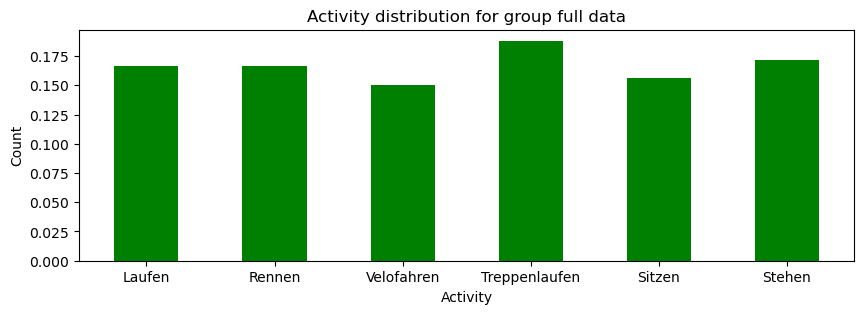

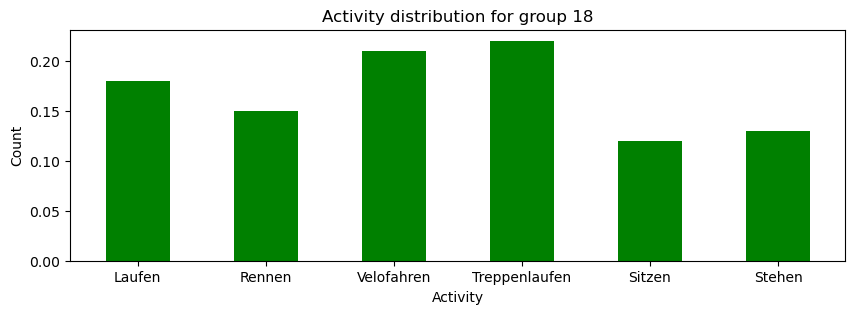

In [21]:
# check split distribution
result_lst = [result_17, result_18]
plot_activity_distribution(label_proportions,'full data')
for i in range(len(result_lst)):
    test_dict = collections.Counter(result_lst[i][5].numpy())
    plot_activity_distribution(test_dict,i+17)